- 单位
    - K：10^3, 1e3, 千，thousand
    - M: 10^6, 1e6, 百万，million
    - G: 10^9, 1e9, 10亿，billion
    - T: 10^12, 1e12, 万亿，trillion
- TFLOPS, TFLOPs
    - TFLOPs：复数概念，多少个浮点数运算
    - TFLOPS：速度概念，每秒多少个浮点数运算
- transformer layer: BERT, GPT2, T5
    - (multi head attn) + ffn
    - multi head attn
        - 兼容 self attention 和 cross attention
        - 而 cross attn 只出现在 encoder + decoder 都有的情况
- 参考（李沐大神）
    - https://www.bilibili.com/video/BV1LT411F77M
    - https://github.com/mli/transformers-benchmarks/blob/main/micro_bench.ipynb

# Mirco-Benchmarking for Transformers

This notebook benchmarks the most time consuming components in BERT, GPT-2 and T5 to help you understand its performance. Let's first check our libraries and hardware. If your GPUs are recent models, please make sure your CUDA version is also recent, which may greatly affect the performance.

In [1]:
import torch

print('Pytorch version\t:', torch.__version__)
print('CUDA version\t:', torch.version.cuda)
print('GPU\t\t:',torch.cuda.get_device_name())

Pytorch version	: 2.0.0+cu118
CUDA version	: 11.8
GPU		: NVIDIA GeForce RTX 4090


Let's first define a `walltime` method to benchmark Pytorch statements by at least 3 seconds. 

In [2]:
import inspect
from collections import defaultdict
import pandas as pd
from torch.utils import benchmark 

pd.options.display.precision = 3

def var_dict(*args):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return dict([(name, val) for name, val in callers_local_vars if val is arg][0] 
                for arg in args)

def walltime(stmt, arg_dict, duration=3):
    return benchmark.Timer(stmt=stmt, globals=arg_dict).blocked_autorange(
        min_run_time=duration).median

Last install huggingface from source code.

In [4]:
# 安装最新版本的 transformer（最新版本，源码安装）
from IPython.display import clear_output

!git clone git@github.com:huggingface/transformers.git
!cd transformers; pip install .

clear_output()

In [5]:
import transformers
print(transformers.__version__)

4.30.0.dev0


## Matrix Multiplication

Matrix multiplication is the most used operator in Transformers. Its performance is crucial. Let's test the [TFLOPS](https://en.wikipedia.org/wiki/FLOPS) we can achieve on square matrices. 

- TFLOPS：每s运行了多少次 tf（浮点运算），速度概念
    - TFLOPs：复数的概念
- $c_{n\cdot n}=a_{n\cdot n}\cdot b_{n\cdot n}$
    - 我们从结果（$c_{n\cdot n}$）出发，它的每一个位置（entry），都是由 $n$ 次乘法 + $n$ 次加法（准确地说是 $n-1$ 次加法）组成（矢量内积）
        - n+(n-1) = 2n-1 == 2n
    - $(n+n)\cdot n\cdot n=2n^3$
- 更高的 tflops：更大的矩阵乘法，float32 => float16
- float16
    - cuBLAS，使用 tensor cores；

In [6]:
# dict of dict
from tqdm import tqdm
matmul_tflops = defaultdict(lambda: {})
for n in tqdm([128, 512, 2*1024, 4*1024, 8*1024, 16*1024, 32*1024]):
    for dtype in (torch.float32, torch.float16):
        a = torch.randn(n, n, dtype=dtype).cuda()
        b = torch.randn(n, n, dtype=dtype).cuda()   
        t = walltime('a @ b', var_dict(a, b))
        matmul_tflops[f'n={n}'][dtype] = 2*n**3 / t / 1e12
        del a, b
        
pd.DataFrame(matmul_tflops)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:40<00:00, 31.54s/it]


,n=128,n=512,n=2048,n=4096,n=8192,n=16384,n=32768
torch.float32,0.592,24.036,53.795,49.005,52.182,51.423,45.631
torch.float16,0.573,35.177,164.255,166.949,156.083,173.988,172.340


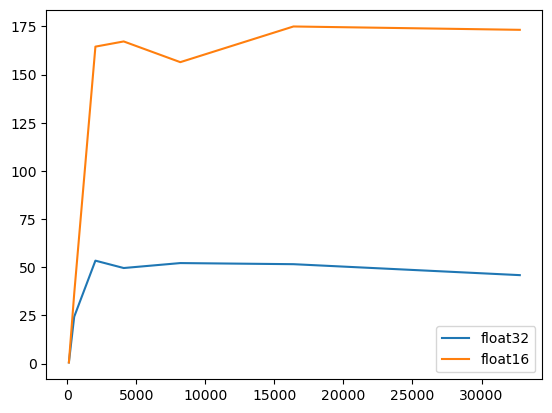

In [13]:
import matplotlib.pyplot as plt
xs = [128, 512, 2*1024, 4*1024, 8*1024, 16*1024, 32*1024]
plt.plot(xs, list(map(lambda x: matmul_tflops[f'n={x}'][torch.float32], xs)))
plt.plot(xs, list(map(lambda x: matmul_tflops[f'n={x}'][torch.float16], xs)))
plt.legend(['float32', 'float16'])

In [10]:
print('torch.float32', 53.795/42.056)
print('torch.float16', 173.988/81.314)

torch.float32 1.279127829560586
torch.float16 2.1397053397938857


You can see that the performance increases with the matrix size. If your GPU has [Tensor Cores](https://www.nvidia.com/en-us/data-center/tensor-cores/), you will see a big performance jump when switching from 32-bit floating points to 16-bit floating points.

Next you can find the theory TFLOPS of your GPU from Wikipedia, for example, [Nvidia Tesla](https://en.wikipedia.org/wiki/Ampere_(microarchitecture)), [Nvidia Quadro](https://en.wikipedia.org/wiki/Quadro), [RTX 40xx](https://en.wikipedia.org/wiki/GeForce_40_series), [RTX 30xx](https://en.wikipedia.org/wiki/GeForce_30_series), and [RTX 20xx](https://en.wikipedia.org/wiki/GeForce_20_series). Here we list several cards, with their memory information.

| Model       | Memory (GB) | Memory Bandwidth (GB/sec) | FP32 TFLOPS | FP16 TFLOPS |
| ----------- | ----------- | ------------------------- | ----------- | ----------- |
| A100        | 80          | 2039                      | 19.5        | 312         |
| V100        | 16          | 900                       | 15.7        | 125         |
| A6000       | 48          | 768                       | 38          | 150         |
| RTX 3090 TI | 24          | 1008                      | 40          | 160         |
| RTX 4090    | 24          | 1008                      | 82          | 330         |


If the best TFLOPS number you got is still far away from the theory TFLOPS of your GPU, the performance is likely bottlenecked by the memory bandwidth. To illustrate it, let's benchmark a simple elemental-wise multiplication to show both its TFLOPS with memory bandwidth. 

- 深度学习中的按元素（element wise）运算：
    - 一个layer的输出，经过 activate function；
    - 权重的更新；

In [22]:
vector = defaultdict(lambda: {})
# *4
for n in [1024*64, 1024*256, 1024*1024, 1024*1024*4, 1024*1024*16, 1024*1024*64]:
    a = torch.randn(n).cuda()
    t = walltime('a * 1.2', var_dict(a))
    vector[n]['TFLOPS'] = n / t / 1e12
    # float32: 4 Byte;
    # 读写：两个操作；
    vector[n]['GB/s'] = (4*2) * n / t / 1e9
    
pd.DataFrame(vector)

,65536,262144,1048576,4194304,16777216,67108864
TFLOPS,0.009,0.043,0.173,0.472,0.115,0.115
GB/s,70.541,343.917,1385.415,3777.138,920.339,921.202


You can see that even for large vectors, the TFLOPS is far far way from GPU peak performance, while the bandwidth may be quite close to its theoretical number.

The matrix multiplication performance is a main topic in HPC. There are a large number of research papers. Unfortunately the backend library, cuBLAS, is not open sourced. You may check [cutlass](https://github.com/NVIDIA/cutlass), which claimed similar performance as cuBLAS, for some implementation details.


## BERT Layer

The main body of a Transformer model is a stacking of Transformer blocks. Let's benchmark the performance of a single block. In BERT, it is often called a BERT layer. Let's construct one such layer from the [BERT large model](https://huggingface.co/bert-large-uncased). We use 16-bit floating points for better performance. 

In [13]:
from transformers import AutoConfig, BertLayer

config = AutoConfig.from_pretrained("bert-large-uncased")
layer = BertLayer(config).half().cuda()

In [23]:
config

BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [20]:
# multihead attention: 64*16
print(config.hidden_size)

1024


Then define a function to benchmark both forward and forward with backward performance using different sequence lengths and batch sizes. 

- input_shape: (b, s, h)
- ffn：
    - 两层 mlp，h=>4h=>h
        - h->4h
            - (b, h)\*(h, 4h) => (b, 4h)
            - (b\*4h)(2\*h) == 8\*b\*h\*h
        - 4h->h
            - (b, 4h)\*(4h, h) => (b, h)
            - (b\*h)\*(2\*4\*h) == 8\*b\*h\*h
        - 16\*b\*h\*h
        - 16\*b\*s\*h\*h
- attn：假如有 n 个头，每个头的维度：h/n（Q，K，V）
    - 三步
       - 第一步先做投影，
           - Q: (s, h) * (h, h/n) ==> (s, h/n)
               - s\*(h/n)\*(2h)
           - K: (s, h) * (h, h/n) ==> (s, h/n)
               - s\*(h/n)\*(2h)
           - V: (s, h) * (h, h/n) ==> (s, h/n)
               - s\*(h/n)\*(2h)
           - s\*(h/n)\*(2h)\*3 = 6\*(h\*h/n)\*s
       - 再计算 attn_score: (Q\*K^T)\*V
           - (s, h/n) \* (h/n, s) => (s, s)
               - s\*s*(2h/n)
           - (s,s)\*(s, h/n) => (s, h/n)
               - (s\*h/n)*(2s)
           - s\*s\*(2h/n) + (s\*h/n)\*(2s) = 4\*(h/n)\*s\*s
       - n个(h/n) concat 为 h，做一次投影 (s, h) => (s, h)
           - (6\*(h\*h/n)\*s + 4\*(h/n)\*s\*s) * n = 6\*s\*h\*h + 4\*h\*s\*s
           - (s, h) \* (h, h) => (s, h) 
               - s\*h\*(2\*h) = 2\*s\*h\*h
       - 6\*s\*h\*h + 4\*h\*s\*s + 2\*s\*h\*h = 8\*s\*h\*h + 4\*h\*s\*s
       

In [16]:
def layer_benchmark(layer, hidden_size, seq_lens, batch_sizes, cross_attention=False):
    h = hidden_size
    results = defaultdict(lambda: {})    
    encoder_state = 'encoder_hidden_states=X' if cross_attention else ''
    for s in seq_lens:
        for b in batch_sizes:            
            ffn = 16*b*s*h*h / 1e12  # TFLOPs for the Feed-Forward Network
            atten = (4*b*h*s*s + 8*b*s*h*h) / 1e12  # TFLOPs for attention            
            forward = ffn + (2 if cross_attention else 1) * atten
            
            X = torch.randn(b, s, h).half().cuda()
            results[f'batch={b}'][f'fwd seq_len={s}'] = forward / walltime(
                f'layer(X, {encoder_state})', var_dict(layer, X))
            results[f'batch={b}'][f'fwd+bwd seq_len={s}'] = 3 * forward / walltime(
                f'layer(X, {encoder_state})[0].sum().backward()', var_dict(layer, X))            
    return pd.DataFrame(results)

In BERT pre-training, we often train with a sequence of 128 (stage 1) or 512 (stage 2). Let's test its performance. 

In [17]:
layer_benchmark(layer, config.hidden_size, [128, 512], [2, 4, 8, 16, 32, 64, 128])

,batch=2,batch=4,batch=8,batch=16,batch=32,batch=64,batch=128
fwd seq_len=128,11.511,13.321,45.993,53.099,107.170,110.394,97.590
fwd+bwd seq_len=128,3.129,6.341,12.523,25.068,49.649,99.831,102.060
fwd seq_len=512,29.852,82.675,76.396,73.583,71.270,68.964,69.280
fwd+bwd seq_len=512,13.490,26.978,53.157,80.533,76.346,78.427,78.398


In [24]:
110.394/56.488

1.9542911768871265

No surprise that a large batch size helps. But the best number is below the matrix multiplication TFLOPS. Let's find why.

We first benchmark the first dense layer in the Feed-Forward Network (FFN) in the layer. 

In [26]:
# ffn 中的其中一层 mlp, h=>4h
layer.intermediate.dense

Linear(in_features=1024, out_features=4096, bias=True)

In [29]:
h, b, s = config.hidden_size, 64, 128
X = torch.randn(b, s, h).half().cuda()

'Dense layer TFLOPS: %.3f' % (8*b*s*h*h / 1e12 / walltime(    
    'layer.intermediate.dense(X)', var_dict(layer, X)))

'Dense layer TFLOPS: 160.980'

The number is pretty good. Then run this dense layer with the GeLU activation.

In [21]:
# ffn 中的其中一层 mlp
layer.intermediate

BertIntermediate(
  (dense): Linear(in_features=1024, out_features=4096, bias=True)
  (intermediate_act_fn): GELUActivation()
)

In [30]:
'Dense+Activation TFLOPS: %.3f' % (8*b*s*h*h / 1e12 / walltime(
    'layer.intermediate(X)', var_dict(layer, X)))

'Dense+Activation TFLOPS: 126.240'

Even the activation function has a ignorable complexity, it brings down the TFLOPS. We pointed out the reason before, the elemental-wise operation of the activation function is bounded by the memory bandwidth.

Now test the whole FFN.

In [31]:
ffn = 16*b*s*h*h / 1e12
'FFN TFLOPS: %.3f'%(ffn / walltime(
    'layer.output(layer.intermediate(X),X)', var_dict(layer, X)))

'FFN TFLOPS: 135.765'

The other part in the BERT layer is the multi-head self-attention.

In [32]:
att = (4*b*h*s*s + 8*b*s*h*h) / 1e12
'Attention TFLOPS: %.3f'%(
    att / walltime('layer.attention(X)', var_dict(layer, X)))

'Attention TFLOPS: 81.950'

Even though the main computation part of the attention block is still matrix multiplication, it has more memory bounded operators compared to FFN. So you see a lower TFLOPS.

In [33]:
att / ffn

0.53125

The ratio of complexity between attention and FFN depends on the BERT configuration. The overall performance is a weighted sum between the FLOPS of these two components.

## GPT-2 Block

Next let's evaluate `gpt2-medium`, which has a similar architecture has `bert-large`, i.e. 24 layers with a 1024 hidden size. GPT2 is trained with a 1024 sequence length.

In [34]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

config = AutoConfig.from_pretrained("gpt2-medium")
layer = GPT2Block(config, layer_idx=0).half().cuda()
layer_benchmark(layer, config.n_embd, [512, 1024], [2, 4, 8, 16, 32, 64])

,batch=2,batch=4,batch=8,batch=16,batch=32,batch=64
fwd seq_len=512,25.072,49.734,56.900,49.412,48.346,47.935
fwd+bwd seq_len=512,12.614,25.118,49.785,54.885,53.958,54.169
fwd seq_len=1024,44.208,43.629,39.372,38.740,38.568,38.427
fwd+bwd seq_len=1024,27.067,44.980,44.579,43.975,44.094,44.113


In [27]:
56.900/36.595

1.5548572209318212

You can see that, despite GPT-2 and BERT has the same complexity, GPT-2 has slightly worse TFLOPS when using the same batch size and sequence length. Also using a larger sequence length 1024 further harms the performance.

## T5 Layer

T5 has both encoder and decoder, let's first benchmark the decoder, whose performance is similar to BERT.

In [35]:
from transformers.models.t5.modeling_t5 import T5Block

config = AutoConfig.from_pretrained("t5-large")
config.use_cache = False
config.is_decoder = False
config.is_encoder_decoder = False

encoder = T5Block(config).half().cuda()
layer_benchmark(encoder, config.d_model, [512], [2, 4, 8, 16, 32, 64, 128])

,batch=2,batch=4,batch=8,batch=16,batch=32,batch=64,batch=128
fwd seq_len=512,19.052,50.302,47.720,45.154,43.313,41.821,41.524
fwd+bwd seq_len=512,10.798,21.681,41.511,52.429,49.602,49.603,49.468


The decoder has an additional cross attention, which increases the time complexity and also hurts TFLOPS.

In [36]:
config.is_decoder = True
decoder = T5Block(config).half().cuda()
layer_benchmark(decoder, config.d_model, [512], [2, 4, 8, 16, 32, 64, 128], cross_attention=True)

,batch=2,batch=4,batch=8,batch=16,batch=32,batch=64,batch=128
fwd seq_len=512,29.277,40.767,38.341,36.989,35.458,34.330,34.084
fwd+bwd seq_len=512,9.257,18.400,36.701,42.897,40.398,40.718,40.643


## Conclusion

To conclude, to achieve the best performance for a Transformer layer, you need to use a fast data type and a large batch size. For further improvement, we may need to rewrite the code. For example, [fusing](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#fuse-pointwise-operations) multiple kernels into a single one. 